# Read in the data

In [2]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey


# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]

In [11]:
import matplotlib.pyplot as plt

survey_fields_sat = survey_fields + ["sat_score"]
survey_sat = combined[survey_fields_sat]
survey_sat_corr = survey_sat.corr()
#print(survey_sat_corr)

* Why is the correlation with eng_t_10 Not A Number?

In [12]:
combined[survey_fields_sat].plot.scatter(x="saf_s_11", y="sat_score")
plt.show()
%matplotlib inline

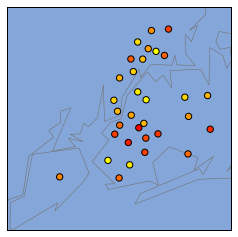

In [17]:
districts = combined.groupby("school_dist", as_index=False).mean()

from mpl_toolkits.basemap import Basemap
m = Basemap(projection='merc', llcrnrlat=40.496044, urcrnrlat=40.915256, llcrnrlon=-74.255735, urcrnrlon=-73.700272,resolution='i')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longtitute = districts["lon"].tolist()
latitute = districts["lat"].tolist()

m.scatter(longtitute, latitute, s=40, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="autumn")

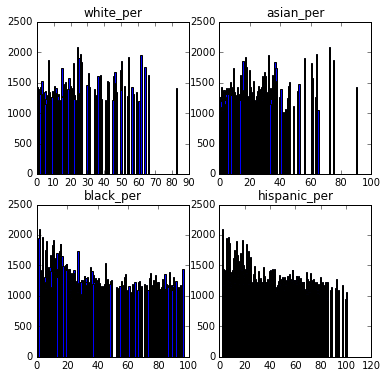

In [21]:
races = ["white_per", "asian_per", "black_per", "hispanic_per"]

fig = plt.figure(figsize=(6,6))

for num in range(0,4):
    ax = fig.add_subplot(2,2,num+1)
    ax.bar(combined[races[num]], combined["sat_score"])
    ax.set_title(races[num])

*The higher the percentage of black or hispanic students, the lower the sat score

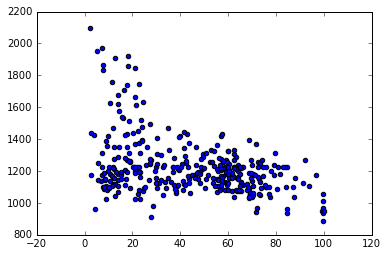

In [24]:
plt.scatter(combined["hispanic_per"], combined["sat_score"])

In [49]:
high_hisp = combined["SCHOOL NAME"][combined["hispanic_per"]>95]
print(high_hisp.head())

0        HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES
1                  UNIVERSITY NEIGHBORHOOD HIGH SCHOOL
2                           EAST SIDE COMMUNITY SCHOOL
3                              MARTA VALLE HIGH SCHOOL
4    NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...
Name: SCHOOL NAME, dtype: object


In [65]:
low_hisp = combined[combined["hispanic_per"]<10]
low_hisp_good = low_hisp["SCHOOL NAME"][low_hisp["sat_score"] > 1800]
print(low_hisp_good.head())

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


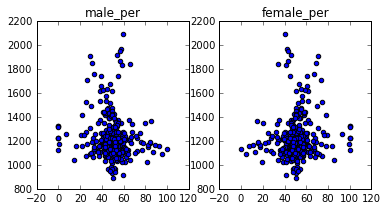

In [75]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(combined["male_per"], combined["sat_score"])
ax1.set_title("male_per")
ax2 = fig.add_subplot(1,2,2)
ax2.scatter(combined["female_per"], combined["sat_score"])
ax2.set_title("female_per")

In [80]:
more_female = combined["SCHOOL NAME"][(combined["female_per"]>60) & (combined["sat_score"]>1700)]
print(more_female.head)

<bound method Series.head of 5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object>


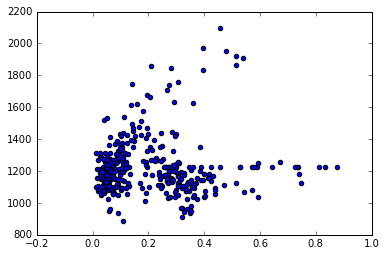

In [81]:
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"]
plt.scatter(combined["ap_per"], combined["sat_score"])